In [71]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import netCDF4
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import h5py as h5
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim,ll_to_xy
import pandas as pd
import csv

In [72]:
filename = "ncf_20170108_024049.nc"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

In [73]:
lat = ncfile2['lat0']
lon = ncfile2['lon0']
reflectivity = ncfile2['DBZH'][:].squeeze()

In [74]:
filename = "ERA5_CRSIM_0240"
ncfile3 = Dataset(filename)
ncfile4 = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

In [75]:
mlat = ncfile3['xlat'][:].squeeze()
mlon = ncfile3['xlong'][:].squeeze()
zhh = ncfile3['Zhh'][:].squeeze()

In [76]:
#Read in each file name
file_name = ['ncf_20170108_022049.nc','ncf_20170108_023048.nc','ncf_20170108_024049.nc','ncf_20170108_025048.nc','ncf_20170108_030049.nc','ncf_20170108_031048.nc','ncf_20170108_032048.nc','ncf_20170108_033048.nc','ncf_20170108_034048.nc','ncf_20170108_035048.nc','ncf_20170108_040048.nc','ncf_20170108_041048.nc','ncf_20170108_042048.nc','ncf_20170108_043048.nc','ncf_20170108_044048.nc','ncf_20170108_045048.nc','ncf_20170108_050048.nc','ncf_20170108_051048.nc','ncf_20170108_052048.nc','ncf_20170108_054048.nc','ncf_20170108_055048.nc']

In [77]:
#Get the initial composite reflectivity
arr = np.max(reflectivity, axis = 0)
arr = np.array(arr)

crsim_composite = np.max(zhh, axis = 0)
crsim_composite = np.array(crsim_composite)

In [78]:
#What we are trying to do is find the areas that are blocked by the terrain. To do that, we must 
#add up all the composites, then mask the areas that don't have anything.

# Set the inital composite.
total_composite = arr

for title in file_name:
    file = Dataset(title)
    reflect = ncfile['DBZH'][:].squeeze()
    total_composite = total_composite + np.max(reflectivity, axis = 0)
total_composite = np.array(total_composite)

#Now find the value where there is no data (blocked) It should be super high
#because blank values are super high in the composite array

maxer = 0
x = 0
y = 0

while x < 1001:
    while y < 1001:
        if total_composite[y,x] >= maxer:
            maxer = total_composite[y,x]
        y = y + 1
    y = 0
    x = x + 1

In [79]:

#Create the crsim_composite that's the same shape as the binary array 
crsim_sameshape  = np.zeros((109,110))
crsim_sameshape = crsim_composite[17:126,15:125]


In [80]:
#269:385,343:456
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

request = cimgt.StamenTerrain()   # very responsive
crg = request.crs

#Loop through crsim area
y = 17
x = 15

#Define arrays for each crsim point
lat_list = ma.array(np.zeros((109,110)))
lon_list = ma.array(np.zeros((109,110)))
radar_av = ma.array(np.zeros((109,110)))
tests = ma.array(np.zeros((109,110)))
o_frac = ma.array(np.zeros((109,110)))
m_frac= ma.array(np.zeros((109,110)))
radar_av = ma.array(radar_av)
ct = 0
    
while y < 126:
    while x < 125:
        
        
        latitude = mlat[y,x]
        longitude = mlon[y,x]
        
        #Here we get the box each data point the radar data is in. We're converting it to the same shape as crsim
        #Find the edges of the gridspace by finding the points around it
        left_edge = (mlon[y,x-1] + longitude)/2
        right_edge = (mlon[y,x+1] + longitude)/2
        top = (mlat[y+1,x] + latitude)/2
        bottom = (mlat[y-1,x] + latitude)/2
        
        #Get the points in that box
        index = np.where((lon > left_edge) & (lon < right_edge) & (lat < top) & (lat > bottom))
        
        #Take the points in there that are less than 50 dbs
        radar_obs=  np.nanmean(arr[index[0],index[1]][np.where(arr[index[0],index[1]] < 50)])
        
        #Get the composite values in that box. If it's super high, then it's beam blocked
        ismask = np.nanmean(total_composite[index[0],index[1]])

        ct = ct + 1
        
        #Get the lat, lon, of that grispace. Finally, get the radar average of that gridspace, and put it in the radar_av array
        longitude, latitude =crg.transform_point(longitude, latitude, ccrs.Geodetic())
        
        #Put those points in. Subtracting because we're going from the crisim points, to a new array of the same shape
        lon_list[(y-17),(x-15)] = (longitude)
        lat_list[(y-17),(x-15)]= latitude
        radar_av[(y-17),(x-15)] = radar_obs
        
        #Finding if that composite values in the box are super high, if it is, mask that part of the array
        if ismask >=maxer:
            crsim_sameshape[(y-17),(x-15)] = ma.masked
            radar_av[(y-17),(x-15)] = ma.masked
            tests[(y-17),(x-15)] = 1
            m_frac[(y-17),(x-15)] = ma.masked
            o_frac[(y-17),(x-15)] = ma.masked
            
        x = x + 1
    x = 15
    y = y + 1
        

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Warning: converting a masked element to nan.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [ ]:
#THE FOUR CORNERS

#Define the theresholdsand loop through each one
threshlist = [1,5,10,15,20,25]
for z in threshlist:
    
    #Define the model fraction arrays
    model_frac = np.zeros((109,110))
    obs_frac = np.zeros((109,110))

    threshold = z

    #These cells are hard coded fractions for the corerns, and sides.
    
    
    #TOP LEFT
    corner_list = []
    corner_list.append(radar_av[108,0])
    corner_list.append(radar_av[107,0])
    corner_list.append(radar_av[108,1])
    corner_list.append(radar_av[107,1])
    corner_list = np.array(corner_list)
    obs_frac[108,0] = len(np.where(corner_list > threshold)[0])/9


    #BOTTOM LEFT

    corner_list = []
    corner_list.append(radar_av[0,0])
    corner_list.append(radar_av[1,0])
    corner_list.append(radar_av[1,1])
    corner_list.append(radar_av[0,1])
    corner_list = np.array(corner_list)
    obs_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT

    corner_list = []
    corner_list.append(radar_av[108,109])
    corner_list.append(radar_av[107,109])
    corner_list.append(radar_av[108,108])
    corner_list.append(radar_av[107,108])
    corner_list = np.array(corner_list)
    obs_frac[108,109] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT

    corner_list = []
    corner_list.append(radar_av[0,109])
    corner_list.append(radar_av[0,108])
    corner_list.append(radar_av[1,109])
    corner_list.append(radar_av[1,108])
    corner_list = np.array(corner_list)
    obs_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

    #LEFT SIDE
    y = 107

    while y >0:
        area = []
        area.append(radar_av[y,0])
        area.append(radar_av[y,1])
        area.append(radar_av[y+1,0])
        area.append(radar_av[y+1,1])
        area.append(radar_av[y-1,0])
        area.append(radar_av[y-1,1])
        area = np.array(area)
        obs_frac[y,0] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT SIDE
    y = 107

    while y >0:
        area = []
        area.append(radar_av[y,109])
        area.append(radar_av[y,108])
        area.append(radar_av[y+1,109])
        area.append(radar_av[y+1,108])
        area.append(radar_av[y-1,109])
        area.append(radar_av[y-1,108])
        area = np.array(area)
        obs_frac[y,109] = len(np.where(area > threshold)[0])/9
        y = y -1

    #TOP SIDE
    x = 108

    while x >0:
        area = []
        area.append(radar_av[108,x])
        area.append(radar_av[108,x-1])
        area.append(radar_av[108,x+1])
        area.append(radar_av[107,x])
        area.append(radar_av[107,x-1])
        area.append(radar_av[107,x+1])
        area = np.array(area)
        obs_frac[108,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM SIDE
    x = 108

    while x >0:
        area = []
        area.append(radar_av[0,x])
        area.append(radar_av[0,x-1])
        area.append(radar_av[0,x+1])
        area.append(radar_av[1,x])
        area.append(radar_av[1,x-1])
        area.append(radar_av[1,x+1])
        area = np.array(area)
        obs_frac[0,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    
    #Now that we have the sides and corners (that will likely be ommited anyways)
    
    #Loop from 1 - >10X because we already defined the sides
    
    #ALL INSIDE POINTS
    #X 1 -> 108
    #Y 1-> 107

    y = 1
    x = 1
    
    #Loop through each point
    while y < 108:
        while x < 109:
            area = []
            #Get the surrounding points
            area.append(radar_av[y,x])
            area.append(radar_av[y+1,x-1])
            area.append(radar_av[y+1,x])
            area.append(radar_av[y+1,x+1])
            area.append(radar_av[y,x-1])
            area.append(radar_av[y,x+1])
            area.append(radar_av[y-1,x-1])
            area.append(radar_av[y-1,x])
            area.append(radar_av[y-1,x+1])
            
            
            area = np.array(area)
            
            #Find the number of points that were not nan, ( blocked), and make that the denominator
            denom = len(np.where(area>=0)[0])
            if denom == 0:
                denom = 9
            obs_frac[y,x] = len(np.where(area > threshold)[0])/denom
            if denom == 0:
                obs_frac[y,x] = np.nan

            x = x +1
        x = 0
        y = y + 1
        


    #TOP LEFT
    corner_list = []
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[107,1])
    corner_list = np.array(corner_list)
    model_frac[108,0] = len(np.where(corner_list > threshold)[0])/9


    #BOTTOM LEFT

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[0,1])
    corner_list = np.array(corner_list)
    model_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[108,109])
    corner_list.append(crsim_sameshape[107,109])
    corner_list.append(crsim_sameshape[108,108])
    corner_list.append(crsim_sameshape[107,108])
    corner_list = np.array(corner_list)
    model_frac[108,109] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list = np.array(corner_list)
    model_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

    #LEFT SIDE
    y = 107

    while y >0:
        area = []
        area.append(crsim_sameshape[y,0])
        area.append(crsim_sameshape[y,1])
        area.append(crsim_sameshape[y+1,0])
        area.append(crsim_sameshape[y+1,1])
        area.append(crsim_sameshape[y-1,0])
        area.append(crsim_sameshape[y-1,1])
        area = np.array(area)
        model_frac[y,0] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT SIDE
    y = 107

    while y >0:
        area = []
        area.append(crsim_sameshape[y,109])
        area.append(crsim_sameshape[y,108])
        area.append(crsim_sameshape[y+1,109])
        area.append(crsim_sameshape[y+1,108])
        area.append(crsim_sameshape[y-1,109])
        area.append(crsim_sameshape[y-1,108])
        area = np.array(area)
        model_frac[y,109] = len(np.where(area > threshold)[0])/9
        y = y -1

    #TOP SIDE
    x = 108

    while x >0:
        area = []
        area.append(crsim_sameshape[108,x])
        area.append(crsim_sameshape[108,x-1])
        area.append(crsim_sameshape[108,x+1])
        area.append(crsim_sameshape[107,x])
        area.append(crsim_sameshape[107,x-1])
        area.append(crsim_sameshape[107,x+1])
        area = np.array(area)
        model_frac[108,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM SIDE
    x = 108

    while x >0:
        area = []
        area.append(crsim_sameshape[0,x])
        area.append(crsim_sameshape[0,x-1])
        area.append(crsim_sameshape[0,x+1])
        area.append(crsim_sameshape[1,x])
        area.append(crsim_sameshape[1,x-1])
        area.append(crsim_sameshape[1,x+1])
        area = np.array(area)
        model_frac[0,x] = len(np.where(area > threshold)[0])/9
        x = x -1


    #ALL INSIDE POINTS
    #X 1 -> 108
    #Y 1-> 107

    y = 1
    x = 1
    while y < 108:
        while x < 109:
            area = []
            area.append(crsim_sameshape[y,x])
            area.append(crsim_sameshape[y+1,x-1])
            area.append(crsim_sameshape[y+1,x])
            area.append(crsim_sameshape[y+1,x+1])
            area.append(crsim_sameshape[y,x-1])
            area.append(crsim_sameshape[y,x+1])
            area.append(crsim_sameshape[y-1,x-1])
            area.append(crsim_sameshape[y-1,x])
            area.append(crsim_sameshape[y-1,x+1])

            area = np.array(area)
            denom = len(np.where(area>=0)[0])
            if denom == 0:
                denom = 9
            model_frac[y,x] = len(np.where(area > threshold)[0])/denom
            if denom == 0:
                model_frac[y,x] = np.nan

            x = x +1
        x = 0
        y = y + 1
    
    #Only pick the points that are not beam blocked. tests ais an array that is equal to 1 when the point is blocekd
    index = np.where(tests ==0)
    MSE =np.nansum((obs_frac[index[0],index[1]] - model_frac[index[0],index[1]])**2)/len(index[0])
    MSEref =np.nansum((obs_frac[index[0],index[1]]**2 + model_frac[index[0],index[1]]**2))/len(index[0])
    print("3X3")
    print(z)
    print(1-(MSE/MSEref))
    print("Useful FSS")
    top = len(np.where(radar_av[index[0],index[1]] > threshold)[0])
    bot = len(radar_av[index[0],index[1]])
    f = top/bot
    usefulfss = .5 + f/2
    print(usefulfss)
print(filename)
print("done")

In [ ]:
for z in threshlist:
    #THE FOUR CORNERS
    #5X5

    model_frac = np.zeros((109,110))
    obs_frac = np.zeros((109,110))
    threshold = z
    crsim_sameshape = crsim_composite[17:126,15:125]
    #TOP LEFT
    corner_list = []
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[106,2])
    corner_list = np.array(corner_list)
    model_frac[108,0] = len(np.where(corner_list > threshold)[0])/9

    #TOP LEFT RIGHT 1
    corner_list = []
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[108,3])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[106,3])
    corner_list = np.array(corner_list)
    model_frac[108,1] = len(np.where(corner_list > threshold)[0])/9


    #TOP LEFT RIGHT DOWN 1
    corner_list = []
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[108,3])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[106,3])

    corner_list = np.array(corner_list)
    model_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

    #TOP LEFT DOWN 1
    corner_list = []
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[105,0])
    corner_list.append(crsim_sameshape[105,1])
    corner_list.append(crsim_sameshape[105,2])

    corner_list = np.array(corner_list)
    model_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list = np.array(corner_list)
    model_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT up 1

    corner_list = []
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[3,2])

    corner_list = np.array(corner_list)
    model_frac[1,0] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT up 1 right

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[0,3])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[1,3])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[2,3])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[3,2])
    corner_list.append(crsim_sameshape[3,3])
    corner_list = np.array(corner_list)
    model_frac[1,1] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT right

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[3,2])
    corner_list = np.array(corner_list)
    model_frac[0,1] = len(np.where(corner_list > threshold)[0])/9


    #TOP RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[108,109])
    corner_list.append(crsim_sameshape[107,109])
    corner_list.append(crsim_sameshape[106,109])
    corner_list.append(crsim_sameshape[108,108])
    corner_list.append(crsim_sameshape[107,108])
    corner_list.append(crsim_sameshape[106,108])
    corner_list.append(crsim_sameshape[108,107])
    corner_list.append(crsim_sameshape[107,107])
    corner_list.append(crsim_sameshape[106,107])
    corner_list = np.array(corner_list)
    model_frac[108,109] = len(np.where(corner_list > threshold)[0])/9


    #TOP RIGHT Down 1
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109]) 
    corner_list.append(crsim_sameshape[105,109]) 
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108]) 
    corner_list.append(crsim_sameshape[105,108]) 
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[105,107]) 

    corner_list = np.array(corner_list)
    model_frac[107,109] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT Down 1 left
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109]) 
    corner_list.append(crsim_sameshape[105,109]) 
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108]) 
    corner_list.append(crsim_sameshape[105,108]) 
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[105,107])
    corner_list.append(crsim_sameshape[108,106]) 
    corner_list.append(crsim_sameshape[107,106]) 
    corner_list.append(crsim_sameshape[106,106]) 
    corner_list.append(crsim_sameshape[105,106]) 

    corner_list = np.array(corner_list)
    model_frac[107,108] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT left
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109])  
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108])  
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[108,106]) 
    corner_list.append(crsim_sameshape[107,106]) 
    corner_list.append(crsim_sameshape[106,106])

    corner_list = np.array(corner_list)
    model_frac[108,108] = len(np.where(corner_list > threshold)[0])/9



    #BOTTOM RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list = np.array(corner_list)
    model_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT left

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[0,106])
    corner_list.append(crsim_sameshape[1,106])
    corner_list.append(crsim_sameshape[2,106])
    corner_list = np.array(corner_list)
    model_frac[0,108] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT left down 1

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[0,106])
    corner_list.append(crsim_sameshape[1,106])
    corner_list.append(crsim_sameshape[2,106])
    corner_list.append(crsim_sameshape[3,106])
    corner_list.append(crsim_sameshape[3,109])
    corner_list.append(crsim_sameshape[3,107])
    corner_list.append(crsim_sameshape[3,108])
    corner_list = np.array(corner_list)
    model_frac[1,108] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT up 1

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[3,107])
    corner_list.append(crsim_sameshape[3,108])
    corner_list.append(crsim_sameshape[3,109])
    corner_list = np.array(corner_list)
    model_frac[1,109] = len(np.where(corner_list > threshold)[0])/9

    #LEFT LEFT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,0])
        area.append(crsim_sameshape[y,1])
        area.append(crsim_sameshape[y,2])
        area.append(crsim_sameshape[y+1,0])
        area.append(crsim_sameshape[y+1,1])
        area.append(crsim_sameshape[y+1,2])
        area.append(crsim_sameshape[y+2,0])
        area.append(crsim_sameshape[y+2,1])
        area.append(crsim_sameshape[y+2,2])
        area.append(crsim_sameshape[y-1,0])
        area.append(crsim_sameshape[y-1,1])
        area.append(crsim_sameshape[y-1,2])
        area.append(crsim_sameshape[y-2,0])
        area.append(crsim_sameshape[y-2,1])
        area.append(crsim_sameshape[y-2,2])
        area = np.array(area)
        model_frac[y,0] = len(np.where(area > threshold)[0])/9
        y = y -1

    #LEFT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,0])
        area.append(crsim_sameshape[y,1])
        area.append(crsim_sameshape[y,2])
        area.append(crsim_sameshape[y+1,0])
        area.append(crsim_sameshape[y+1,1])
        area.append(crsim_sameshape[y+1,2])
        area.append(crsim_sameshape[y+2,0])
        area.append(crsim_sameshape[y+2,1])
        area.append(crsim_sameshape[y+2,2])
        area.append(crsim_sameshape[y-1,0])
        area.append(crsim_sameshape[y-1,1])
        area.append(crsim_sameshape[y-1,2])
        area.append(crsim_sameshape[y-2,0])
        area.append(crsim_sameshape[y-2,1])
        area.append(crsim_sameshape[y-2,2])
        area.append(crsim_sameshape[y-2,3])
        area.append(crsim_sameshape[y-1,3])
        area.append(crsim_sameshape[y,3])
        area.append(crsim_sameshape[y+1,3])
        area.append(crsim_sameshape[y+2,3])
        area = np.array(area)
        model_frac[y,1] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT RIGHT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,109])
        area.append(crsim_sameshape[y,108])
        area.append(crsim_sameshape[y,107])
        area.append(crsim_sameshape[y+1,109])
        area.append(crsim_sameshape[y+1,108])
        area.append(crsim_sameshape[y+1,107])
        area.append(crsim_sameshape[y+2,109])
        area.append(crsim_sameshape[y+2,108])
        area.append(crsim_sameshape[y+2,107])    
        area.append(crsim_sameshape[y-1,109])
        area.append(crsim_sameshape[y-1,108])
        area.append(crsim_sameshape[y-1,107])
        area.append(crsim_sameshape[y-2,109])
        area.append(crsim_sameshape[y-2,108])
        area.append(crsim_sameshape[y-2,107])
        area = np.array(area)
        model_frac[y,109] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT SIDE
    y = 106

    while y >0:
        area = []
        area.append(crsim_sameshape[y,109])
        area.append(crsim_sameshape[y,108])
        area.append(crsim_sameshape[y,107])
        area.append(crsim_sameshape[y+1,109])
        area.append(crsim_sameshape[y+1,108])
        area.append(crsim_sameshape[y+1,107])
        area.append(crsim_sameshape[y+2,109])
        area.append(crsim_sameshape[y+2,108])
        area.append(crsim_sameshape[y+2,107])    
        area.append(crsim_sameshape[y-1,109])
        area.append(crsim_sameshape[y-1,108])
        area.append(crsim_sameshape[y-1,107])
        area.append(crsim_sameshape[y-2,109])
        area.append(crsim_sameshape[y-2,108])
        area.append(crsim_sameshape[y-2,107])
        area.append(crsim_sameshape[y-2,106])
        area.append(crsim_sameshape[y-1,106])
        area.append(crsim_sameshape[y,106])
        area.append(crsim_sameshape[y+1,106])
        area.append(crsim_sameshape[y+2,106])
        area = np.array(area)
        model_frac[y,108] = len(np.where(area > threshold)[0])/9
        y = y -1

    #TOP TOP SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[108,x])
        area.append(crsim_sameshape[108,x-1])
        area.append(crsim_sameshape[108,x+1])
        area.append(crsim_sameshape[108,x+2])
        area.append(crsim_sameshape[108,x-2])
        area.append(crsim_sameshape[107,x])
        area.append(crsim_sameshape[107,x-1])
        area.append(crsim_sameshape[107,x+1])
        area.append(crsim_sameshape[106,x])
        area.append(crsim_sameshape[106,x-1])
        area.append(crsim_sameshape[106,x-2])
        area.append(crsim_sameshape[106,x+1])
        area.append(crsim_sameshape[106,x+2])
        area = np.array(area)
        model_frac[108,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #TOP SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[108,x])
        area.append(crsim_sameshape[108,x-1])
        area.append(crsim_sameshape[108,x+1])
        area.append(crsim_sameshape[108,x+2])
        area.append(crsim_sameshape[108,x-2])
        area.append(crsim_sameshape[107,x])
        area.append(crsim_sameshape[107,x-1])
        area.append(crsim_sameshape[107,x+1])
        area.append(crsim_sameshape[106,x])
        area.append(crsim_sameshape[106,x-1])
        area.append(crsim_sameshape[106,x-2])
        area.append(crsim_sameshape[106,x+1])
        area.append(crsim_sameshape[106,x+2])
        area.append(crsim_sameshape[105,x])
        area.append(crsim_sameshape[105,x-1])
        area.append(crsim_sameshape[105,x-2])
        area.append(crsim_sameshape[105,x+1])
        area.append(crsim_sameshape[105,x+2])
        area = np.array(area)
        model_frac[107,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM BOTTOM SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[0,x])
        area.append(crsim_sameshape[0,x-1])
        area.append(crsim_sameshape[0,x+1])
        area.append(crsim_sameshape[0,x+2])
        area.append(crsim_sameshape[0,x-2])
        area.append(crsim_sameshape[1,x])
        area.append(crsim_sameshape[1,x-1])
        area.append(crsim_sameshape[1,x+1])
        area.append(crsim_sameshape[1,x+2])
        area.append(crsim_sameshape[1,x-2])
        area.append(crsim_sameshape[2,x])
        area.append(crsim_sameshape[2,x-1])
        area.append(crsim_sameshape[2,x+1])
        area.append(crsim_sameshape[2,x+2])
        area.append(crsim_sameshape[2,x-2])
        area = np.array(area)
        model_frac[0,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[0,x])
        area.append(crsim_sameshape[0,x-1])
        area.append(crsim_sameshape[0,x+1])
        area.append(crsim_sameshape[0,x+2])
        area.append(crsim_sameshape[0,x-2])
        area.append(crsim_sameshape[1,x])
        area.append(crsim_sameshape[1,x-1])
        area.append(crsim_sameshape[1,x+1])
        area.append(crsim_sameshape[1,x+2])
        area.append(crsim_sameshape[1,x-2])
        area.append(crsim_sameshape[2,x])
        area.append(crsim_sameshape[2,x-1])
        area.append(crsim_sameshape[2,x+1])
        area.append(crsim_sameshape[2,x+2])
        area.append(crsim_sameshape[2,x-2])
        area.append(crsim_sameshape[3,x])
        area.append(crsim_sameshape[3,x-1])
        area.append(crsim_sameshape[3,x+1])
        area.append(crsim_sameshape[3,x+2])
        area.append(crsim_sameshape[3,x-2])
        area = np.array(area)
        model_frac[1,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #ALL INSIDE POINTS
    #X 1 -> 108
    #Y 1-> 107

    y = 2
    x = 2
    while y < 107:
        while x < 108:
            area = []
            area.append(crsim_sameshape[y,x])
            area.append(crsim_sameshape[y+2,x-2])
            area.append(crsim_sameshape[y+2,x-1])
            area.append(crsim_sameshape[y+2,x])
            area.append(crsim_sameshape[y+2,x+1])
            area.append(crsim_sameshape[y+2,x+2])
            area.append(crsim_sameshape[y+1,x-2])
            area.append(crsim_sameshape[y+1,x-1])
            area.append(crsim_sameshape[y+1,x])
            area.append(crsim_sameshape[y+1,x+1])
            area.append(crsim_sameshape[y+1,x+2])
            area.append(crsim_sameshape[y,x-2])
            area.append(crsim_sameshape[y,x-1])
            area.append(crsim_sameshape[y,x+1])
            area.append(crsim_sameshape[y,x+2])
            area.append(crsim_sameshape[y-1,x-2])
            area.append(crsim_sameshape[y-1,x-1])
            area.append(crsim_sameshape[y-1,x])
            area.append(crsim_sameshape[y-1,x+1])
            area.append(crsim_sameshape[y-1,x+2])
            area.append(crsim_sameshape[y-2,x-2])
            area.append(crsim_sameshape[y-2,x-1])
            area.append(crsim_sameshape[y-2,x])
            area.append(crsim_sameshape[y-2,x+1])
            area.append(crsim_sameshape[y-2,x+2])


            area = np.array(area)
            denom = len(np.where(area>=0)[0])
            if denom == 0:
                denom = 9
            model_frac[y,x] = len(np.where(area > threshold)[0])/denom

            x = x +1
        x = 0
        y = y + 1
        
    crsim_sameshape = radar_av


    #TOP LEFT
    corner_list = []
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[106,2])
    corner_list = np.array(corner_list)
    obs_frac[108,0] = len(np.where(corner_list > threshold)[0])/9

    #TOP LEFT RIGHT 1
    corner_list = []
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[108,3])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[106,3])
    corner_list = np.array(corner_list)
    obs_frac[108,1] = len(np.where(corner_list > threshold)[0])/9


    #TOP LEFT RIGHT DOWN 1
    corner_list = []
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[108,3])
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[107,3])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[106,3])

    corner_list = np.array(corner_list)
    obs_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

    #TOP LEFT DOWN 1
    corner_list = []
    corner_list.append(crsim_sameshape[107,0])
    corner_list.append(crsim_sameshape[107,1])
    corner_list.append(crsim_sameshape[107,2])
    corner_list.append(crsim_sameshape[108,0])
    corner_list.append(crsim_sameshape[108,1])
    corner_list.append(crsim_sameshape[108,2])
    corner_list.append(crsim_sameshape[106,0])
    corner_list.append(crsim_sameshape[106,1])
    corner_list.append(crsim_sameshape[106,2])
    corner_list.append(crsim_sameshape[105,0])
    corner_list.append(crsim_sameshape[105,1])
    corner_list.append(crsim_sameshape[105,2])

    corner_list = np.array(corner_list)
    obs_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list = np.array(corner_list)
    obs_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT up 1

    corner_list = []
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[3,2])

    corner_list = np.array(corner_list)
    obs_frac[1,0] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT up 1 right

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[0,3])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[1,3])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[2,3])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[3,2])
    corner_list.append(crsim_sameshape[3,3])
    corner_list = np.array(corner_list)
    obs_frac[1,1] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM LEFT right

    corner_list = []
    corner_list.append(crsim_sameshape[0,0])
    corner_list.append(crsim_sameshape[0,1])
    corner_list.append(crsim_sameshape[0,2])
    corner_list.append(crsim_sameshape[1,0])
    corner_list.append(crsim_sameshape[1,1])
    corner_list.append(crsim_sameshape[1,2])
    corner_list.append(crsim_sameshape[2,0])
    corner_list.append(crsim_sameshape[2,1])
    corner_list.append(crsim_sameshape[2,2])
    corner_list.append(crsim_sameshape[3,0])
    corner_list.append(crsim_sameshape[3,1])
    corner_list.append(crsim_sameshape[3,2])
    corner_list = np.array(corner_list)
    obs_frac[0,1] = len(np.where(corner_list > threshold)[0])/9


    #TOP RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[108,109])
    corner_list.append(crsim_sameshape[107,109])
    corner_list.append(crsim_sameshape[106,109])
    corner_list.append(crsim_sameshape[108,108])
    corner_list.append(crsim_sameshape[107,108])
    corner_list.append(crsim_sameshape[106,108])
    corner_list.append(crsim_sameshape[108,107])
    corner_list.append(crsim_sameshape[107,107])
    corner_list.append(crsim_sameshape[106,107])
    corner_list = np.array(corner_list)
    obs_frac[108,109] = len(np.where(corner_list > threshold)[0])/9


    #TOP RIGHT Down 1
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109]) 
    corner_list.append(crsim_sameshape[105,109]) 
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108]) 
    corner_list.append(crsim_sameshape[105,108]) 
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[105,107]) 

    corner_list = np.array(corner_list)
    obs_frac[107,109] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT Down 1 left
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109]) 
    corner_list.append(crsim_sameshape[105,109]) 
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108]) 
    corner_list.append(crsim_sameshape[105,108]) 
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[105,107])
    corner_list.append(crsim_sameshape[108,106]) 
    corner_list.append(crsim_sameshape[107,106]) 
    corner_list.append(crsim_sameshape[106,106]) 
    corner_list.append(crsim_sameshape[105,106]) 

    corner_list = np.array(corner_list)
    obs_frac[107,108] = len(np.where(corner_list > threshold)[0])/9

    #TOP RIGHT left
    corner_list = []
    corner_list.append(crsim_sameshape[108,109]) 
    corner_list.append(crsim_sameshape[107,109]) 
    corner_list.append(crsim_sameshape[106,109])  
    corner_list.append(crsim_sameshape[108,108]) 
    corner_list.append(crsim_sameshape[107,108]) 
    corner_list.append(crsim_sameshape[106,108])  
    corner_list.append(crsim_sameshape[108,107]) 
    corner_list.append(crsim_sameshape[107,107]) 
    corner_list.append(crsim_sameshape[106,107]) 
    corner_list.append(crsim_sameshape[108,106]) 
    corner_list.append(crsim_sameshape[107,106]) 
    corner_list.append(crsim_sameshape[106,106])

    corner_list = np.array(corner_list)
    obs_frac[108,108] = len(np.where(corner_list > threshold)[0])/9



    #BOTTOM RIGHT

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list = np.array(corner_list)
    obs_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT left

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[0,106])
    corner_list.append(crsim_sameshape[1,106])
    corner_list.append(crsim_sameshape[2,106])
    corner_list = np.array(corner_list)
    obs_frac[0,108] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT left down 1

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[0,106])
    corner_list.append(crsim_sameshape[1,106])
    corner_list.append(crsim_sameshape[2,106])
    corner_list.append(crsim_sameshape[3,106])
    corner_list.append(crsim_sameshape[3,109])
    corner_list.append(crsim_sameshape[3,107])
    corner_list.append(crsim_sameshape[3,108])
    corner_list = np.array(corner_list)
    obs_frac[1,108] = len(np.where(corner_list > threshold)[0])/9

    #BOTTOM RIGHT up 1

    corner_list = []
    corner_list.append(crsim_sameshape[0,109])
    corner_list.append(crsim_sameshape[0,108])
    corner_list.append(crsim_sameshape[0,107])
    corner_list.append(crsim_sameshape[1,109])
    corner_list.append(crsim_sameshape[1,108])
    corner_list.append(crsim_sameshape[1,107])
    corner_list.append(crsim_sameshape[2,109])
    corner_list.append(crsim_sameshape[2,108])
    corner_list.append(crsim_sameshape[2,107])
    corner_list.append(crsim_sameshape[3,107])
    corner_list.append(crsim_sameshape[3,108])
    corner_list.append(crsim_sameshape[3,109])
    corner_list = np.array(corner_list)
    obs_frac[1,109] = len(np.where(corner_list > threshold)[0])/9

    #LEFT LEFT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,0])
        area.append(crsim_sameshape[y,1])
        area.append(crsim_sameshape[y,2])
        area.append(crsim_sameshape[y+1,0])
        area.append(crsim_sameshape[y+1,1])
        area.append(crsim_sameshape[y+1,2])
        area.append(crsim_sameshape[y+2,0])
        area.append(crsim_sameshape[y+2,1])
        area.append(crsim_sameshape[y+2,2])
        area.append(crsim_sameshape[y-1,0])
        area.append(crsim_sameshape[y-1,1])
        area.append(crsim_sameshape[y-1,2])
        area.append(crsim_sameshape[y-2,0])
        area.append(crsim_sameshape[y-2,1])
        area.append(crsim_sameshape[y-2,2])
        area = np.array(area)
        obs_frac[y,0] = len(np.where(area > threshold)[0])/9
        y = y -1

    #LEFT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,0])
        area.append(crsim_sameshape[y,1])
        area.append(crsim_sameshape[y,2])
        area.append(crsim_sameshape[y+1,0])
        area.append(crsim_sameshape[y+1,1])
        area.append(crsim_sameshape[y+1,2])
        area.append(crsim_sameshape[y+2,0])
        area.append(crsim_sameshape[y+2,1])
        area.append(crsim_sameshape[y+2,2])
        area.append(crsim_sameshape[y-1,0])
        area.append(crsim_sameshape[y-1,1])
        area.append(crsim_sameshape[y-1,2])
        area.append(crsim_sameshape[y-2,0])
        area.append(crsim_sameshape[y-2,1])
        area.append(crsim_sameshape[y-2,2])
        area.append(crsim_sameshape[y-2,3])
        area.append(crsim_sameshape[y-1,3])
        area.append(crsim_sameshape[y,3])
        area.append(crsim_sameshape[y+1,3])
        area.append(crsim_sameshape[y+2,3])
        area = np.array(area)
        obs_frac[y,1] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT RIGHT SIDE
    y = 106

    while y >1:
        area = []
        area.append(crsim_sameshape[y,109])
        area.append(crsim_sameshape[y,108])
        area.append(crsim_sameshape[y,107])
        area.append(crsim_sameshape[y+1,109])
        area.append(crsim_sameshape[y+1,108])
        area.append(crsim_sameshape[y+1,107])
        area.append(crsim_sameshape[y+2,109])
        area.append(crsim_sameshape[y+2,108])
        area.append(crsim_sameshape[y+2,107])    
        area.append(crsim_sameshape[y-1,109])
        area.append(crsim_sameshape[y-1,108])
        area.append(crsim_sameshape[y-1,107])
        area.append(crsim_sameshape[y-2,109])
        area.append(crsim_sameshape[y-2,108])
        area.append(crsim_sameshape[y-2,107])
        area = np.array(area)
        obs_frac[y,109] = len(np.where(area > threshold)[0])/9
        y = y -1

    #RIGHT SIDE
    y = 106

    while y >0:
        area = []
        area.append(crsim_sameshape[y,109])
        area.append(crsim_sameshape[y,108])
        area.append(crsim_sameshape[y,107])
        area.append(crsim_sameshape[y+1,109])
        area.append(crsim_sameshape[y+1,108])
        area.append(crsim_sameshape[y+1,107])
        area.append(crsim_sameshape[y+2,109])
        area.append(crsim_sameshape[y+2,108])
        area.append(crsim_sameshape[y+2,107])    
        area.append(crsim_sameshape[y-1,109])
        area.append(crsim_sameshape[y-1,108])
        area.append(crsim_sameshape[y-1,107])
        area.append(crsim_sameshape[y-2,109])
        area.append(crsim_sameshape[y-2,108])
        area.append(crsim_sameshape[y-2,107])
        area.append(crsim_sameshape[y-2,106])
        area.append(crsim_sameshape[y-1,106])
        area.append(crsim_sameshape[y,106])
        area.append(crsim_sameshape[y+1,106])
        area.append(crsim_sameshape[y+2,106])
        area = np.array(area)
        obs_frac[y,108] = len(np.where(area > threshold)[0])/9
        y = y -1

    #TOP TOP SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[108,x])
        area.append(crsim_sameshape[108,x-1])
        area.append(crsim_sameshape[108,x+1])
        area.append(crsim_sameshape[108,x+2])
        area.append(crsim_sameshape[108,x-2])
        area.append(crsim_sameshape[107,x])
        area.append(crsim_sameshape[107,x-1])
        area.append(crsim_sameshape[107,x+1])
        area.append(crsim_sameshape[106,x])
        area.append(crsim_sameshape[106,x-1])
        area.append(crsim_sameshape[106,x-2])
        area.append(crsim_sameshape[106,x+1])
        area.append(crsim_sameshape[106,x+2])
        area = np.array(area)
        obs_frac[108,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #TOP SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[108,x])
        area.append(crsim_sameshape[108,x-1])
        area.append(crsim_sameshape[108,x+1])
        area.append(crsim_sameshape[108,x+2])
        area.append(crsim_sameshape[108,x-2])
        area.append(crsim_sameshape[107,x])
        area.append(crsim_sameshape[107,x-1])
        area.append(crsim_sameshape[107,x+1])
        area.append(crsim_sameshape[106,x])
        area.append(crsim_sameshape[106,x-1])
        area.append(crsim_sameshape[106,x-2])
        area.append(crsim_sameshape[106,x+1])
        area.append(crsim_sameshape[106,x+2])
        area.append(crsim_sameshape[105,x])
        area.append(crsim_sameshape[105,x-1])
        area.append(crsim_sameshape[105,x-2])
        area.append(crsim_sameshape[105,x+1])
        area.append(crsim_sameshape[105,x+2])
        area = np.array(area)
        obs_frac[107,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM BOTTOM SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[0,x])
        area.append(crsim_sameshape[0,x-1])
        area.append(crsim_sameshape[0,x+1])
        area.append(crsim_sameshape[0,x+2])
        area.append(crsim_sameshape[0,x-2])
        area.append(crsim_sameshape[1,x])
        area.append(crsim_sameshape[1,x-1])
        area.append(crsim_sameshape[1,x+1])
        area.append(crsim_sameshape[1,x+2])
        area.append(crsim_sameshape[1,x-2])
        area.append(crsim_sameshape[2,x])
        area.append(crsim_sameshape[2,x-1])
        area.append(crsim_sameshape[2,x+1])
        area.append(crsim_sameshape[2,x+2])
        area.append(crsim_sameshape[2,x-2])
        area = np.array(area)
        obs_frac[0,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #BOTTOM SIDE
    x = 107

    while x >1:
        area = []
        area.append(crsim_sameshape[0,x])
        area.append(crsim_sameshape[0,x-1])
        area.append(crsim_sameshape[0,x+1])
        area.append(crsim_sameshape[0,x+2])
        area.append(crsim_sameshape[0,x-2])
        area.append(crsim_sameshape[1,x])
        area.append(crsim_sameshape[1,x-1])
        area.append(crsim_sameshape[1,x+1])
        area.append(crsim_sameshape[1,x+2])
        area.append(crsim_sameshape[1,x-2])
        area.append(crsim_sameshape[2,x])
        area.append(crsim_sameshape[2,x-1])
        area.append(crsim_sameshape[2,x+1])
        area.append(crsim_sameshape[2,x+2])
        area.append(crsim_sameshape[2,x-2])
        area.append(crsim_sameshape[3,x])
        area.append(crsim_sameshape[3,x-1])
        area.append(crsim_sameshape[3,x+1])
        area.append(crsim_sameshape[3,x+2])
        area.append(crsim_sameshape[3,x-2])
        area = np.array(area)
        obs_frac[1,x] = len(np.where(area > threshold)[0])/9
        x = x -1

    #ALL INSIDE POINTS
    #X 1 -> 108
    #Y 1-> 107
    ctt = 0
    cttt = 0
    y = 2
    x = 2
    while y < 107:
        while x < 108:
            area = []
            area.append(crsim_sameshape[y,x])
            area.append(crsim_sameshape[y+2,x-2])
            area.append(crsim_sameshape[y+2,x-1])
            area.append(crsim_sameshape[y+2,x])
            area.append(crsim_sameshape[y+2,x+1])
            area.append(crsim_sameshape[y+2,x+2])
            area.append(crsim_sameshape[y+1,x-2])
            area.append(crsim_sameshape[y+1,x-1])
            area.append(crsim_sameshape[y+1,x])
            area.append(crsim_sameshape[y+1,x+1])
            area.append(crsim_sameshape[y+1,x+2])
            area.append(crsim_sameshape[y,x-2])
            area.append(crsim_sameshape[y,x-1])
            area.append(crsim_sameshape[y,x+1])
            area.append(crsim_sameshape[y,x+2])
            area.append(crsim_sameshape[y-1,x-2])
            area.append(crsim_sameshape[y-1,x-1])
            area.append(crsim_sameshape[y-1,x])
            area.append(crsim_sameshape[y-1,x+1])
            area.append(crsim_sameshape[y-1,x+2])
            area.append(crsim_sameshape[y-2,x-2])
            area.append(crsim_sameshape[y-2,x-1])
            area.append(crsim_sameshape[y-2,x])
            area.append(crsim_sameshape[y-2,x+1])
            area.append(crsim_sameshape[y-2,x+2])

            area = np.array(area)
            denom = len(np.where(area>=0)[0])
            if denom == 0:
                denom = 9
            
                
            obs_frac[y,x] = len(np.where(area > threshold)[0])/denom

            x = x +1
        x = 0
        y = y + 1
    index = np.where(tests ==0)
    MSE =np.nansum((obs_frac[index[0],index[1]] - model_frac[index[0],index[1]])**2)/len(index[0])
    MSEref =np.nansum((obs_frac[index[0],index[1]]**2 + model_frac[index[0],index[1]]**2))/len(index[0])
    print("5X5")
    print(z)
    print(1-(MSE/MSEref))
print("done")

In [81]:
#THE FOUR CORNERS
obs_frac = ma.array(np.zeros((109,110)))

threshold = 1

#TOP LEFT
corner_list = []
corner_list.append(radar_av[108,0])
corner_list.append(radar_av[107,0])
corner_list.append(radar_av[108,1])
corner_list.append(radar_av[107,1])
corner_list = np.array(corner_list)
obs_frac[108,0] = len(np.where(corner_list > threshold)[0])/9


#BOTTOM LEFT

corner_list = []
corner_list.append(radar_av[0,0])
corner_list.append(radar_av[1,0])
corner_list.append(radar_av[1,1])
corner_list.append(radar_av[0,1])
corner_list = np.array(corner_list)
obs_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT

corner_list = []
corner_list.append(radar_av[108,109])
corner_list.append(radar_av[107,109])
corner_list.append(radar_av[108,108])
corner_list.append(radar_av[107,108])
corner_list = np.array(corner_list)
obs_frac[108,109] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT

corner_list = []
corner_list.append(radar_av[0,109])
corner_list.append(radar_av[0,108])
corner_list.append(radar_av[1,109])
corner_list.append(radar_av[1,108])
corner_list = np.array(corner_list)
obs_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

#LEFT SIDE
y = 107

while y >0:
    area = []
    area.append(radar_av[y,0])
    area.append(radar_av[y,1])
    area.append(radar_av[y+1,0])
    area.append(radar_av[y+1,1])
    area.append(radar_av[y-1,0])
    area.append(radar_av[y-1,1])
    area = np.array(area)
    obs_frac[y,0] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT SIDE
y = 107

while y >0:
    area = []
    area.append(radar_av[y,109])
    area.append(radar_av[y,108])
    area.append(radar_av[y+1,109])
    area.append(radar_av[y+1,108])
    area.append(radar_av[y-1,109])
    area.append(radar_av[y-1,108])
    area = np.array(area)
    obs_frac[y,109] = len(np.where(area > threshold)[0])/9
    y = y -1
    
#TOP SIDE
x = 108

while x >0:
    area = []
    area.append(radar_av[108,x])
    area.append(radar_av[108,x-1])
    area.append(radar_av[108,x+1])
    area.append(radar_av[107,x])
    area.append(radar_av[107,x-1])
    area.append(radar_av[107,x+1])
    area = np.array(area)
    obs_frac[108,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#BOTTOM SIDE
x = 108

while x >0:
    area = []
    area.append(radar_av[0,x])
    area.append(radar_av[0,x-1])
    area.append(radar_av[0,x+1])
    area.append(radar_av[1,x])
    area.append(radar_av[1,x-1])
    area.append(radar_av[1,x+1])
    area = np.array(area)
    obs_frac[0,x] = len(np.where(area > threshold)[0])/9
    x = x -1
    
    
#ALL INSIDE POINTS
#X 1 -> 108
#Y 1-> 107

y = 1
x = 1
while y < 108:
    while x < 109:
        area = []
        area.append(radar_av[y,x])
        area.append(radar_av[y+1,x-1])
        area.append(radar_av[y+1,x])
        area.append(radar_av[y+1,x+1])
        area.append(radar_av[y,x-1])
        area.append(radar_av[y,x+1])
        area.append(radar_av[y-1,x-1])
        area.append(radar_av[y-1,x])
        area.append(radar_av[y-1,x+1])
        
        area = np.array(area)
        denom = len(np.where(area>=0)[0])
        if denom == 0:
            denom = 9
        obs_frac[y,x] = len(np.where(area > threshold)[0])/denom
        
        x = x +1
    x = 0
    y = y + 1
print("done")

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: converting a masked element to 

done


In [82]:
#THE FOUR CORNERS
model_frac = ma.array(np.zeros((109,110)))
threshold = 1

#TOP LEFT
corner_list = []
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[107,1])
corner_list = np.array(corner_list)
model_frac[108,0] = len(np.where(corner_list > threshold)[0])/9


#BOTTOM LEFT

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[0,1])
corner_list = np.array(corner_list)
model_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT

corner_list = []
corner_list.append(crsim_sameshape[108,109])
corner_list.append(crsim_sameshape[107,109])
corner_list.append(crsim_sameshape[108,108])
corner_list.append(crsim_sameshape[107,108])
corner_list = np.array(corner_list)
model_frac[108,109] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list = np.array(corner_list)
model_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

#LEFT SIDE
y = 107

while y >0:
    area = []
    area.append(crsim_sameshape[y,0])
    area.append(crsim_sameshape[y,1])
    area.append(crsim_sameshape[y+1,0])
    area.append(crsim_sameshape[y+1,1])
    area.append(crsim_sameshape[y-1,0])
    area.append(crsim_sameshape[y-1,1])
    area = np.array(area)
    model_frac[y,0] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT SIDE
y = 107

while y >0:
    area = []
    area.append(crsim_sameshape[y,109])
    area.append(crsim_sameshape[y,108])
    area.append(crsim_sameshape[y+1,109])
    area.append(crsim_sameshape[y+1,108])
    area.append(crsim_sameshape[y-1,109])
    area.append(crsim_sameshape[y-1,108])
    area = np.array(area)
    model_frac[y,109] = len(np.where(area > threshold)[0])/9
    y = y -1
    
#TOP SIDE
x = 108

while x >0:
    area = []
    area.append(crsim_sameshape[108,x])
    area.append(crsim_sameshape[108,x-1])
    area.append(crsim_sameshape[108,x+1])
    area.append(crsim_sameshape[107,x])
    area.append(crsim_sameshape[107,x-1])
    area.append(crsim_sameshape[107,x+1])
    area = np.array(area)
    model_frac[108,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#BOTTOM SIDE
x = 108

while x >0:
    area = []
    area.append(crsim_sameshape[0,x])
    area.append(crsim_sameshape[0,x-1])
    area.append(crsim_sameshape[0,x+1])
    area.append(crsim_sameshape[1,x])
    area.append(crsim_sameshape[1,x-1])
    area.append(crsim_sameshape[1,x+1])
    area = np.array(area)
    model_frac[0,x] = len(np.where(area > threshold)[0])/9
    x = x -1

    
#ALL INSIDE POINTS
#X 1 -> 108
#Y 1-> 107

y = 1
x = 1
while y < 108:
    while x < 109:
        area = []
        area.append(crsim_sameshape[y,x])
        area.append(crsim_sameshape[y+1,x-1])
        area.append(crsim_sameshape[y+1,x])
        area.append(crsim_sameshape[y+1,x+1])
        area.append(crsim_sameshape[y,x-1])
        area.append(crsim_sameshape[y,x+1])
        area.append(crsim_sameshape[y-1,x-1])
        area.append(crsim_sameshape[y-1,x])
        area.append(crsim_sameshape[y-1,x+1])
        
        area = np.array(area)
        denom = len(np.where(area>=0)[0])
        if denom == 0:
            denom = 9
        model_frac[y,x] = len(np.where(area > threshold)[0])/denom
        
        x = x +1
    x = 0
    y = y + 1
print("done")

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater
/glade/u/ssg/ch/usr/jupyterh

done


In [ ]:
import numpy as np
from scipy.stats import chisquare
x = 0
while x < 130:
    print(chisquare(obs_frac[:,x], model_frac[:,x]))
    x = x + 1

In [ ]:
index = np.where(tests ==0)
MSE =np.nansum((obs_frac[index[0],index[1]] - model_frac[index[0],index[1]])**2)/len(index[0])
MSEref =np.nansum((obs_frac[index[0],index[1]]**2 + model_frac[index[0],index[1]]**2))/len(index[0])
print(1-(MSE/MSEref))

In [ ]:
#THE FOUR CORNERS
#5X5
crsim_sameshape = crsim_composite[17:126,15:125]

model_frac = np.zeros((109,110))
threshold = 10

#TOP LEFT
corner_list = []
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[106,2])
corner_list = np.array(corner_list)
model_frac[108,0] = len(np.where(corner_list > threshold)[0])/9

#TOP LEFT RIGHT 1
corner_list = []
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[108,3])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[106,3])
corner_list = np.array(corner_list)
model_frac[108,1] = len(np.where(corner_list > threshold)[0])/9


#TOP LEFT RIGHT DOWN 1
corner_list = []
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[108,3])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[106,3])

corner_list = np.array(corner_list)
model_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

#TOP LEFT DOWN 1
corner_list = []
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[105,0])
corner_list.append(crsim_sameshape[105,1])
corner_list.append(crsim_sameshape[105,2])

corner_list = np.array(corner_list)
model_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[1,2])
corner_list = np.array(corner_list)
model_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT up 1

corner_list = []
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[3,2])

corner_list = np.array(corner_list)
model_frac[1,0] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT up 1 right

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[0,3])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[1,3])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[2,3])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[3,2])
corner_list.append(crsim_sameshape[3,3])
corner_list = np.array(corner_list)
model_frac[1,1] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT right

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[3,2])
corner_list = np.array(corner_list)
model_frac[0,1] = len(np.where(corner_list > threshold)[0])/9


#TOP RIGHT

corner_list = []
corner_list.append(crsim_sameshape[108,109])
corner_list.append(crsim_sameshape[107,109])
corner_list.append(crsim_sameshape[106,109])
corner_list.append(crsim_sameshape[108,108])
corner_list.append(crsim_sameshape[107,108])
corner_list.append(crsim_sameshape[106,108])
corner_list.append(crsim_sameshape[108,107])
corner_list.append(crsim_sameshape[107,107])
corner_list.append(crsim_sameshape[106,107])
corner_list = np.array(corner_list)
model_frac[108,109] = len(np.where(corner_list > threshold)[0])/9


#TOP RIGHT Down 1
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109]) 
corner_list.append(crsim_sameshape[105,109]) 
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108]) 
corner_list.append(crsim_sameshape[105,108]) 
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[105,107]) 

corner_list = np.array(corner_list)
model_frac[107,109] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT Down 1 left
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109]) 
corner_list.append(crsim_sameshape[105,109]) 
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108]) 
corner_list.append(crsim_sameshape[105,108]) 
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[105,107])
corner_list.append(crsim_sameshape[108,106]) 
corner_list.append(crsim_sameshape[107,106]) 
corner_list.append(crsim_sameshape[106,106]) 
corner_list.append(crsim_sameshape[105,106]) 

corner_list = np.array(corner_list)
model_frac[107,108] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT left
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109])  
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108])  
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[108,106]) 
corner_list.append(crsim_sameshape[107,106]) 
corner_list.append(crsim_sameshape[106,106])

corner_list = np.array(corner_list)
model_frac[108,108] = len(np.where(corner_list > threshold)[0])/9



#BOTTOM RIGHT

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list = np.array(corner_list)
model_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT left

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[0,106])
corner_list.append(crsim_sameshape[1,106])
corner_list.append(crsim_sameshape[2,106])
corner_list = np.array(corner_list)
model_frac[0,108] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT left down 1

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[0,106])
corner_list.append(crsim_sameshape[1,106])
corner_list.append(crsim_sameshape[2,106])
corner_list.append(crsim_sameshape[3,106])
corner_list.append(crsim_sameshape[3,109])
corner_list.append(crsim_sameshape[3,107])
corner_list.append(crsim_sameshape[3,108])
corner_list = np.array(corner_list)
model_frac[1,108] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT up 1

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[3,107])
corner_list.append(crsim_sameshape[3,108])
corner_list.append(crsim_sameshape[3,109])
corner_list = np.array(corner_list)
model_frac[1,109] = len(np.where(corner_list > threshold)[0])/9

#LEFT LEFT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,0])
    area.append(crsim_sameshape[y,1])
    area.append(crsim_sameshape[y,2])
    area.append(crsim_sameshape[y+1,0])
    area.append(crsim_sameshape[y+1,1])
    area.append(crsim_sameshape[y+1,2])
    area.append(crsim_sameshape[y+2,0])
    area.append(crsim_sameshape[y+2,1])
    area.append(crsim_sameshape[y+2,2])
    area.append(crsim_sameshape[y-1,0])
    area.append(crsim_sameshape[y-1,1])
    area.append(crsim_sameshape[y-1,2])
    area.append(crsim_sameshape[y-2,0])
    area.append(crsim_sameshape[y-2,1])
    area.append(crsim_sameshape[y-2,2])
    area = np.array(area)
    model_frac[y,0] = len(np.where(area > threshold)[0])/9
    y = y -1

#LEFT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,0])
    area.append(crsim_sameshape[y,1])
    area.append(crsim_sameshape[y,2])
    area.append(crsim_sameshape[y+1,0])
    area.append(crsim_sameshape[y+1,1])
    area.append(crsim_sameshape[y+1,2])
    area.append(crsim_sameshape[y+2,0])
    area.append(crsim_sameshape[y+2,1])
    area.append(crsim_sameshape[y+2,2])
    area.append(crsim_sameshape[y-1,0])
    area.append(crsim_sameshape[y-1,1])
    area.append(crsim_sameshape[y-1,2])
    area.append(crsim_sameshape[y-2,0])
    area.append(crsim_sameshape[y-2,1])
    area.append(crsim_sameshape[y-2,2])
    area.append(crsim_sameshape[y-2,3])
    area.append(crsim_sameshape[y-1,3])
    area.append(crsim_sameshape[y,3])
    area.append(crsim_sameshape[y+1,3])
    area.append(crsim_sameshape[y+2,3])
    area = np.array(area)
    model_frac[y,1] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT RIGHT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,109])
    area.append(crsim_sameshape[y,108])
    area.append(crsim_sameshape[y,107])
    area.append(crsim_sameshape[y+1,109])
    area.append(crsim_sameshape[y+1,108])
    area.append(crsim_sameshape[y+1,107])
    area.append(crsim_sameshape[y+2,109])
    area.append(crsim_sameshape[y+2,108])
    area.append(crsim_sameshape[y+2,107])    
    area.append(crsim_sameshape[y-1,109])
    area.append(crsim_sameshape[y-1,108])
    area.append(crsim_sameshape[y-1,107])
    area.append(crsim_sameshape[y-2,109])
    area.append(crsim_sameshape[y-2,108])
    area.append(crsim_sameshape[y-2,107])
    area = np.array(area)
    model_frac[y,109] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT SIDE
y = 106

while y >0:
    area = []
    area.append(crsim_sameshape[y,109])
    area.append(crsim_sameshape[y,108])
    area.append(crsim_sameshape[y,107])
    area.append(crsim_sameshape[y+1,109])
    area.append(crsim_sameshape[y+1,108])
    area.append(crsim_sameshape[y+1,107])
    area.append(crsim_sameshape[y+2,109])
    area.append(crsim_sameshape[y+2,108])
    area.append(crsim_sameshape[y+2,107])    
    area.append(crsim_sameshape[y-1,109])
    area.append(crsim_sameshape[y-1,108])
    area.append(crsim_sameshape[y-1,107])
    area.append(crsim_sameshape[y-2,109])
    area.append(crsim_sameshape[y-2,108])
    area.append(crsim_sameshape[y-2,107])
    area.append(crsim_sameshape[y-2,106])
    area.append(crsim_sameshape[y-1,106])
    area.append(crsim_sameshape[y,106])
    area.append(crsim_sameshape[y+1,106])
    area.append(crsim_sameshape[y+2,106])
    area = np.array(area)
    model_frac[y,108] = len(np.where(area > threshold)[0])/9
    y = y -1
    
#TOP TOP SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[108,x])
    area.append(crsim_sameshape[108,x-1])
    area.append(crsim_sameshape[108,x+1])
    area.append(crsim_sameshape[108,x+2])
    area.append(crsim_sameshape[108,x-2])
    area.append(crsim_sameshape[107,x])
    area.append(crsim_sameshape[107,x-1])
    area.append(crsim_sameshape[107,x+1])
    area.append(crsim_sameshape[106,x])
    area.append(crsim_sameshape[106,x-1])
    area.append(crsim_sameshape[106,x-2])
    area.append(crsim_sameshape[106,x+1])
    area.append(crsim_sameshape[106,x+2])
    area = np.array(area)
    model_frac[108,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#TOP SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[108,x])
    area.append(crsim_sameshape[108,x-1])
    area.append(crsim_sameshape[108,x+1])
    area.append(crsim_sameshape[108,x+2])
    area.append(crsim_sameshape[108,x-2])
    area.append(crsim_sameshape[107,x])
    area.append(crsim_sameshape[107,x-1])
    area.append(crsim_sameshape[107,x+1])
    area.append(crsim_sameshape[106,x])
    area.append(crsim_sameshape[106,x-1])
    area.append(crsim_sameshape[106,x-2])
    area.append(crsim_sameshape[106,x+1])
    area.append(crsim_sameshape[106,x+2])
    area.append(crsim_sameshape[105,x])
    area.append(crsim_sameshape[105,x-1])
    area.append(crsim_sameshape[105,x-2])
    area.append(crsim_sameshape[105,x+1])
    area.append(crsim_sameshape[105,x+2])
    area = np.array(area)
    model_frac[107,x] = len(np.where(area > threshold)[0])/9
    x = x -1
    
#BOTTOM BOTTOM SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[0,x])
    area.append(crsim_sameshape[0,x-1])
    area.append(crsim_sameshape[0,x+1])
    area.append(crsim_sameshape[0,x+2])
    area.append(crsim_sameshape[0,x-2])
    area.append(crsim_sameshape[1,x])
    area.append(crsim_sameshape[1,x-1])
    area.append(crsim_sameshape[1,x+1])
    area.append(crsim_sameshape[1,x+2])
    area.append(crsim_sameshape[1,x-2])
    area.append(crsim_sameshape[2,x])
    area.append(crsim_sameshape[2,x-1])
    area.append(crsim_sameshape[2,x+1])
    area.append(crsim_sameshape[2,x+2])
    area.append(crsim_sameshape[2,x-2])
    area = np.array(area)
    model_frac[0,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#BOTTOM SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[0,x])
    area.append(crsim_sameshape[0,x-1])
    area.append(crsim_sameshape[0,x+1])
    area.append(crsim_sameshape[0,x+2])
    area.append(crsim_sameshape[0,x-2])
    area.append(crsim_sameshape[1,x])
    area.append(crsim_sameshape[1,x-1])
    area.append(crsim_sameshape[1,x+1])
    area.append(crsim_sameshape[1,x+2])
    area.append(crsim_sameshape[1,x-2])
    area.append(crsim_sameshape[2,x])
    area.append(crsim_sameshape[2,x-1])
    area.append(crsim_sameshape[2,x+1])
    area.append(crsim_sameshape[2,x+2])
    area.append(crsim_sameshape[2,x-2])
    area.append(crsim_sameshape[3,x])
    area.append(crsim_sameshape[3,x-1])
    area.append(crsim_sameshape[3,x+1])
    area.append(crsim_sameshape[3,x+2])
    area.append(crsim_sameshape[3,x-2])
    area = np.array(area)
    model_frac[1,x] = len(np.where(area > threshold)[0])/9
    x = x -1
    
#ALL INSIDE POINTS
#X 1 -> 108
#Y 1-> 107

y = 2
x = 2
while y < 107:
    while x < 108:
        area = []
        area.append(crsim_sameshape[y,x])
        area.append(crsim_sameshape[y+2,x-2])
        area.append(crsim_sameshape[y+2,x-1])
        area.append(crsim_sameshape[y+2,x])
        area.append(crsim_sameshape[y+2,x+1])
        area.append(crsim_sameshape[y+2,x+2])
        area.append(crsim_sameshape[y+1,x-2])
        area.append(crsim_sameshape[y+1,x-1])
        area.append(crsim_sameshape[y+1,x])
        area.append(crsim_sameshape[y+1,x+1])
        area.append(crsim_sameshape[y+1,x+2])
        area.append(crsim_sameshape[y,x-2])
        area.append(crsim_sameshape[y,x-1])
        area.append(crsim_sameshape[y,x+1])
        area.append(crsim_sameshape[y,x+2])
        area.append(crsim_sameshape[y-1,x-2])
        area.append(crsim_sameshape[y-1,x-1])
        area.append(crsim_sameshape[y-1,x])
        area.append(crsim_sameshape[y-1,x+1])
        area.append(crsim_sameshape[y-1,x+2])
        area.append(crsim_sameshape[y-2,x-2])
        area.append(crsim_sameshape[y-2,x-1])
        area.append(crsim_sameshape[y-2,x])
        area.append(crsim_sameshape[y-2,x+1])
        area.append(crsim_sameshape[y-2,x+2])
        
        
        area = np.array(area)
        denom = len(np.where(area>=0)[0])
        if denom == 0:
            denom = 9
        model_frac[y,x] = len(np.where(area > threshold)[0])/denom
        
        x = x +1
    x = 0
    y = y + 1
print("done")

In [ ]:
#THE FOUR CORNERS
#5X5
#INstead of chaging everysingle array of crsim_sameshape to radar_av. I'm just going to make crsim_sameshape = radar_av

crsim_sameshape = radar_av
obs_frac = np.zeros((109,110))
threshold = 1

#TOP LEFT
corner_list = []
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[106,2])
corner_list = np.array(corner_list)
obs_frac[108,0] = len(np.where(corner_list > threshold)[0])/9

#TOP LEFT RIGHT 1
corner_list = []
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[108,3])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[106,3])
corner_list = np.array(corner_list)
obs_frac[108,1] = len(np.where(corner_list > threshold)[0])/9


#TOP LEFT RIGHT DOWN 1
corner_list = []
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[108,3])
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[107,3])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[106,3])

corner_list = np.array(corner_list)
obs_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

#TOP LEFT DOWN 1
corner_list = []
corner_list.append(crsim_sameshape[107,0])
corner_list.append(crsim_sameshape[107,1])
corner_list.append(crsim_sameshape[107,2])
corner_list.append(crsim_sameshape[108,0])
corner_list.append(crsim_sameshape[108,1])
corner_list.append(crsim_sameshape[108,2])
corner_list.append(crsim_sameshape[106,0])
corner_list.append(crsim_sameshape[106,1])
corner_list.append(crsim_sameshape[106,2])
corner_list.append(crsim_sameshape[105,0])
corner_list.append(crsim_sameshape[105,1])
corner_list.append(crsim_sameshape[105,2])

corner_list = np.array(corner_list)
obs_frac[107,1] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[1,2])
corner_list = np.array(corner_list)
obs_frac[0,0] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT up 1

corner_list = []
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[3,2])

corner_list = np.array(corner_list)
obs_frac[1,0] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT up 1 right

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[0,3])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[1,3])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[2,3])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[3,2])
corner_list.append(crsim_sameshape[3,3])
corner_list = np.array(corner_list)
obs_frac[1,1] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM LEFT right

corner_list = []
corner_list.append(crsim_sameshape[0,0])
corner_list.append(crsim_sameshape[0,1])
corner_list.append(crsim_sameshape[0,2])
corner_list.append(crsim_sameshape[1,0])
corner_list.append(crsim_sameshape[1,1])
corner_list.append(crsim_sameshape[1,2])
corner_list.append(crsim_sameshape[2,0])
corner_list.append(crsim_sameshape[2,1])
corner_list.append(crsim_sameshape[2,2])
corner_list.append(crsim_sameshape[3,0])
corner_list.append(crsim_sameshape[3,1])
corner_list.append(crsim_sameshape[3,2])
corner_list = np.array(corner_list)
obs_frac[0,1] = len(np.where(corner_list > threshold)[0])/9


#TOP RIGHT

corner_list = []
corner_list.append(crsim_sameshape[108,109])
corner_list.append(crsim_sameshape[107,109])
corner_list.append(crsim_sameshape[106,109])
corner_list.append(crsim_sameshape[108,108])
corner_list.append(crsim_sameshape[107,108])
corner_list.append(crsim_sameshape[106,108])
corner_list.append(crsim_sameshape[108,107])
corner_list.append(crsim_sameshape[107,107])
corner_list.append(crsim_sameshape[106,107])
corner_list = np.array(corner_list)
obs_frac[108,109] = len(np.where(corner_list > threshold)[0])/9


#TOP RIGHT Down 1
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109]) 
corner_list.append(crsim_sameshape[105,109]) 
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108]) 
corner_list.append(crsim_sameshape[105,108]) 
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[105,107]) 

corner_list = np.array(corner_list)
obs_frac[107,109] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT Down 1 left
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109]) 
corner_list.append(crsim_sameshape[105,109]) 
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108]) 
corner_list.append(crsim_sameshape[105,108]) 
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[105,107])
corner_list.append(crsim_sameshape[108,106]) 
corner_list.append(crsim_sameshape[107,106]) 
corner_list.append(crsim_sameshape[106,106]) 
corner_list.append(crsim_sameshape[105,106]) 

corner_list = np.array(corner_list)
obs_frac[107,108] = len(np.where(corner_list > threshold)[0])/9

#TOP RIGHT left
corner_list = []
corner_list.append(crsim_sameshape[108,109]) 
corner_list.append(crsim_sameshape[107,109]) 
corner_list.append(crsim_sameshape[106,109])  
corner_list.append(crsim_sameshape[108,108]) 
corner_list.append(crsim_sameshape[107,108]) 
corner_list.append(crsim_sameshape[106,108])  
corner_list.append(crsim_sameshape[108,107]) 
corner_list.append(crsim_sameshape[107,107]) 
corner_list.append(crsim_sameshape[106,107]) 
corner_list.append(crsim_sameshape[108,106]) 
corner_list.append(crsim_sameshape[107,106]) 
corner_list.append(crsim_sameshape[106,106])

corner_list = np.array(corner_list)
obs_frac[108,108] = len(np.where(corner_list > threshold)[0])/9



#BOTTOM RIGHT

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list = np.array(corner_list)
obs_frac[0,109] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT left

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[0,106])
corner_list.append(crsim_sameshape[1,106])
corner_list.append(crsim_sameshape[2,106])
corner_list = np.array(corner_list)
obs_frac[0,108] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT left down 1

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[0,106])
corner_list.append(crsim_sameshape[1,106])
corner_list.append(crsim_sameshape[2,106])
corner_list.append(crsim_sameshape[3,106])
corner_list.append(crsim_sameshape[3,109])
corner_list.append(crsim_sameshape[3,107])
corner_list.append(crsim_sameshape[3,108])
corner_list = np.array(corner_list)
obs_frac[1,108] = len(np.where(corner_list > threshold)[0])/9

#BOTTOM RIGHT up 1

corner_list = []
corner_list.append(crsim_sameshape[0,109])
corner_list.append(crsim_sameshape[0,108])
corner_list.append(crsim_sameshape[0,107])
corner_list.append(crsim_sameshape[1,109])
corner_list.append(crsim_sameshape[1,108])
corner_list.append(crsim_sameshape[1,107])
corner_list.append(crsim_sameshape[2,109])
corner_list.append(crsim_sameshape[2,108])
corner_list.append(crsim_sameshape[2,107])
corner_list.append(crsim_sameshape[3,107])
corner_list.append(crsim_sameshape[3,108])
corner_list.append(crsim_sameshape[3,109])
corner_list = np.array(corner_list)
obs_frac[1,109] = len(np.where(corner_list > threshold)[0])/9

#LEFT LEFT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,0])
    area.append(crsim_sameshape[y,1])
    area.append(crsim_sameshape[y,2])
    area.append(crsim_sameshape[y+1,0])
    area.append(crsim_sameshape[y+1,1])
    area.append(crsim_sameshape[y+1,2])
    area.append(crsim_sameshape[y+2,0])
    area.append(crsim_sameshape[y+2,1])
    area.append(crsim_sameshape[y+2,2])
    area.append(crsim_sameshape[y-1,0])
    area.append(crsim_sameshape[y-1,1])
    area.append(crsim_sameshape[y-1,2])
    area.append(crsim_sameshape[y-2,0])
    area.append(crsim_sameshape[y-2,1])
    area.append(crsim_sameshape[y-2,2])
    area = np.array(area)
    obs_frac[y,0] = len(np.where(area > threshold)[0])/9
    y = y -1

#LEFT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,0])
    area.append(crsim_sameshape[y,1])
    area.append(crsim_sameshape[y,2])
    area.append(crsim_sameshape[y+1,0])
    area.append(crsim_sameshape[y+1,1])
    area.append(crsim_sameshape[y+1,2])
    area.append(crsim_sameshape[y+2,0])
    area.append(crsim_sameshape[y+2,1])
    area.append(crsim_sameshape[y+2,2])
    area.append(crsim_sameshape[y-1,0])
    area.append(crsim_sameshape[y-1,1])
    area.append(crsim_sameshape[y-1,2])
    area.append(crsim_sameshape[y-2,0])
    area.append(crsim_sameshape[y-2,1])
    area.append(crsim_sameshape[y-2,2])
    area.append(crsim_sameshape[y-2,3])
    area.append(crsim_sameshape[y-1,3])
    area.append(crsim_sameshape[y,3])
    area.append(crsim_sameshape[y+1,3])
    area.append(crsim_sameshape[y+2,3])
    area = np.array(area)
    obs_frac[y,1] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT RIGHT SIDE
y = 106

while y >1:
    area = []
    area.append(crsim_sameshape[y,109])
    area.append(crsim_sameshape[y,108])
    area.append(crsim_sameshape[y,107])
    area.append(crsim_sameshape[y+1,109])
    area.append(crsim_sameshape[y+1,108])
    area.append(crsim_sameshape[y+1,107])
    area.append(crsim_sameshape[y+2,109])
    area.append(crsim_sameshape[y+2,108])
    area.append(crsim_sameshape[y+2,107])    
    area.append(crsim_sameshape[y-1,109])
    area.append(crsim_sameshape[y-1,108])
    area.append(crsim_sameshape[y-1,107])
    area.append(crsim_sameshape[y-2,109])
    area.append(crsim_sameshape[y-2,108])
    area.append(crsim_sameshape[y-2,107])
    area = np.array(area)
    obs_frac[y,109] = len(np.where(area > threshold)[0])/9
    y = y -1

#RIGHT SIDE
y = 106

while y >0:
    area = []
    area.append(crsim_sameshape[y,109])
    area.append(crsim_sameshape[y,108])
    area.append(crsim_sameshape[y,107])
    area.append(crsim_sameshape[y+1,109])
    area.append(crsim_sameshape[y+1,108])
    area.append(crsim_sameshape[y+1,107])
    area.append(crsim_sameshape[y+2,109])
    area.append(crsim_sameshape[y+2,108])
    area.append(crsim_sameshape[y+2,107])    
    area.append(crsim_sameshape[y-1,109])
    area.append(crsim_sameshape[y-1,108])
    area.append(crsim_sameshape[y-1,107])
    area.append(crsim_sameshape[y-2,109])
    area.append(crsim_sameshape[y-2,108])
    area.append(crsim_sameshape[y-2,107])
    area.append(crsim_sameshape[y-2,106])
    area.append(crsim_sameshape[y-1,106])
    area.append(crsim_sameshape[y,106])
    area.append(crsim_sameshape[y+1,106])
    area.append(crsim_sameshape[y+2,106])
    area = np.array(area)
    obs_frac[y,108] = len(np.where(area > threshold)[0])/9
    y = y -1
    
#TOP TOP SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[108,x])
    area.append(crsim_sameshape[108,x-1])
    area.append(crsim_sameshape[108,x+1])
    area.append(crsim_sameshape[108,x+2])
    area.append(crsim_sameshape[108,x-2])
    area.append(crsim_sameshape[107,x])
    area.append(crsim_sameshape[107,x-1])
    area.append(crsim_sameshape[107,x+1])
    area.append(crsim_sameshape[106,x])
    area.append(crsim_sameshape[106,x-1])
    area.append(crsim_sameshape[106,x-2])
    area.append(crsim_sameshape[106,x+1])
    area.append(crsim_sameshape[106,x+2])
    area = np.array(area)
    obs_frac[108,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#TOP SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[108,x])
    area.append(crsim_sameshape[108,x-1])
    area.append(crsim_sameshape[108,x+1])
    area.append(crsim_sameshape[108,x+2])
    area.append(crsim_sameshape[108,x-2])
    area.append(crsim_sameshape[107,x])
    area.append(crsim_sameshape[107,x-1])
    area.append(crsim_sameshape[107,x+1])
    area.append(crsim_sameshape[106,x])
    area.append(crsim_sameshape[106,x-1])
    area.append(crsim_sameshape[106,x-2])
    area.append(crsim_sameshape[106,x+1])
    area.append(crsim_sameshape[106,x+2])
    area.append(crsim_sameshape[105,x])
    area.append(crsim_sameshape[105,x-1])
    area.append(crsim_sameshape[105,x-2])
    area.append(crsim_sameshape[105,x+1])
    area.append(crsim_sameshape[105,x+2])
    area = np.array(area)
    obs_frac[107,x] = len(np.where(area > threshold)[0])/9
    x = x -1
    
#BOTTOM BOTTOM SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[0,x])
    area.append(crsim_sameshape[0,x-1])
    area.append(crsim_sameshape[0,x+1])
    area.append(crsim_sameshape[0,x+2])
    area.append(crsim_sameshape[0,x-2])
    area.append(crsim_sameshape[1,x])
    area.append(crsim_sameshape[1,x-1])
    area.append(crsim_sameshape[1,x+1])
    area.append(crsim_sameshape[1,x+2])
    area.append(crsim_sameshape[1,x-2])
    area.append(crsim_sameshape[2,x])
    area.append(crsim_sameshape[2,x-1])
    area.append(crsim_sameshape[2,x+1])
    area.append(crsim_sameshape[2,x+2])
    area.append(crsim_sameshape[2,x-2])
    area = np.array(area)
    obs_frac[0,x] = len(np.where(area > threshold)[0])/9
    x = x -1

#BOTTOM SIDE
x = 107

while x >1:
    area = []
    area.append(crsim_sameshape[0,x])
    area.append(crsim_sameshape[0,x-1])
    area.append(crsim_sameshape[0,x+1])
    area.append(crsim_sameshape[0,x+2])
    area.append(crsim_sameshape[0,x-2])
    area.append(crsim_sameshape[1,x])
    area.append(crsim_sameshape[1,x-1])
    area.append(crsim_sameshape[1,x+1])
    area.append(crsim_sameshape[1,x+2])
    area.append(crsim_sameshape[1,x-2])
    area.append(crsim_sameshape[2,x])
    area.append(crsim_sameshape[2,x-1])
    area.append(crsim_sameshape[2,x+1])
    area.append(crsim_sameshape[2,x+2])
    area.append(crsim_sameshape[2,x-2])
    area.append(crsim_sameshape[3,x])
    area.append(crsim_sameshape[3,x-1])
    area.append(crsim_sameshape[3,x+1])
    area.append(crsim_sameshape[3,x+2])
    area.append(crsim_sameshape[3,x-2])
    area = np.array(area)
    obs_frac[1,x] = len(np.where(area > threshold)[0])/9
    x = x -1
    
#ALL INSIDE POINTS
#X 1 -> 108
#Y 1-> 107

y = 2
x = 2
while y < 107:
    while x < 108:
        area = []
        area.append(crsim_sameshape[y,x])
        area.append(crsim_sameshape[y+2,x-2])
        area.append(crsim_sameshape[y+2,x-1])
        area.append(crsim_sameshape[y+2,x])
        area.append(crsim_sameshape[y+2,x+1])
        area.append(crsim_sameshape[y+2,x+2])
        area.append(crsim_sameshape[y+1,x-2])
        area.append(crsim_sameshape[y+1,x-1])
        area.append(crsim_sameshape[y+1,x])
        area.append(crsim_sameshape[y+1,x+1])
        area.append(crsim_sameshape[y+1,x+2])
        area.append(crsim_sameshape[y,x-2])
        area.append(crsim_sameshape[y,x-1])
        area.append(crsim_sameshape[y,x+1])
        area.append(crsim_sameshape[y,x+2])
        area.append(crsim_sameshape[y-1,x-2])
        area.append(crsim_sameshape[y-1,x-1])
        area.append(crsim_sameshape[y-1,x])
        area.append(crsim_sameshape[y-1,x+1])
        area.append(crsim_sameshape[y-1,x+2])
        area.append(crsim_sameshape[y-2,x-2])
        area.append(crsim_sameshape[y-2,x-1])
        area.append(crsim_sameshape[y-2,x])
        area.append(crsim_sameshape[y-2,x+1])
        area.append(crsim_sameshape[y-2,x+2])
        
        
        area = np.array(area)
        denom = len(np.where(area>=0)[0])
        if denom == 0:
            denom = 9
        obs_frac[y,x] = len(np.where(area > threshold)[0])/denom
        
        x = x +1
    x = 0
    y = y + 1
print("done")

In [ ]:
index = np.where(tests ==0)
MSE =np.nansum((obs_frac[index[0],index[1]] - model_frac[index[0],index[1]])**2)/len(index[0])
MSEref ((np.nansum(obs_frac[index[0],index[1]]**2)) + np.nansum(model_frac[index[0],index[1]]**2))/len(index[0])
print(1-(MSE/MSEref))

In [ ]:
((np.nansum(obs_frac[index[0],index[1]]**2)))

In [ ]:
(((np.nansum(obs_frac[index[0],index[1]]**2)))+np.nansum(model_frac[index[0],index[1]]**2))/len(index[0])

In [ ]:
print(MSE)
print(MSEref)

In [ ]:
print(np.nansum((obs_frac[index[0],index[1]])))
print(np.nansum((model_frac[index[0],index[1]])))

In [ ]:
print(np.nansum((obs_frac[index[0],index[1]] - model_frac[index[0],index[1]])**2))
print(np.nansum((obs_frac[index[0],index[1]]**2 + model_frac[index[0],index[1]]**2)))

In [ ]:
index = np.where(tests ==0)

In [ ]:
indz = np.where( crsim_sameshape > 25)
print(len(indz[0]))

In [ ]:
print(np.nansum(np.nansum(((obs_frac[index[0],index[1]]-model_frac[index[0],index[1]])**2)/obs_frac[index[0],index[1]])))
print(len(index[0]))

In [ ]:
print(top)
print(bot)
print(top/bot)

fo = 0.014869
fm = 0.0045598

print((2*fo*fm)/(fo**2 + fm**2))
print(fo/fm)

In [ ]:
#TOP LEFT CORNER: 380, 344
#BOTTOM LEFT CORNER: 270,344
#TOP RIGHT CORNER: 380, 454
#BOTTOM RIGHT CORNER: 270,454

In [83]:
crsim_sameshape[:,0:2] = np.nan
model_frac[:,0:2] = np.nan
obs_frac[:,0:2] = np.nan

In [84]:
index2 = np.where(tests ==1)
model_frac[index2[0],index2[1] ]= np.nan
obs_frac[index2[0],index2[1] ]= np.nan

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  


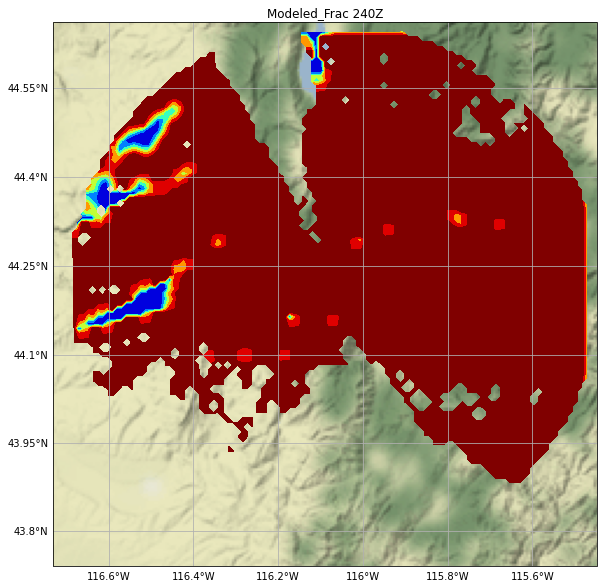

In [86]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

request = cimgt.StamenTerrain()   # very responsive
crg = request.crs

def make_map(projection=crs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)
        # specify map extent here
lonmin, lonmax = -116.73062, -115.44735
latmin, latmax = 43.746786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
#Specificy the range of dBz
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)

rint = 0.05
rmin = 0.01
rmax = 0.90
levs = np.arange(0,30,1)
cont2 =plt.contourf(lon_list, lat_list,model_frac,cmap = "jet", extend = "max" )
#cbr = plt.colorbar(cont2,fraction=0.046, pad=0.04)
#cbr.set_label("X-Band Z [dBZ]")
plt.title("Modeled_Frac 240Z")
plt.savefig("model_fracccc.png")

In [ ]:
arr = np.zeros((111,111))
lat_111 = np.zeros((111,111))
lon_111 = np.zeros((111,111))
import random

latct = 0
lonct = 0

while latct < 110:
    lonct = 0
    while lonct < 110:
        
        r = np.where((lon < lon_list[lonct]) & (lon > lon_list[lonct+1]) & (lat < lat_list[latct])& (lat >lat_list[latct+1]))
        
        lonav = (lon_list[lonct] + lon_list[lonct+1])/2
        latav = (lat_list[latct] + lat_list[latct+1])/2
        
        
        #zavg = np.nanmean(composite[r[0],r[1]])
        #print(np.nanmean(composite[r[0],r[1]]))
        
        
        zavg = random.randint(1,10000)

        
        arr[latct,lonct] = zavg
        lat_111[latct,lonct] = latav
        lon_111[latct,lonct] = lonav
        
        
        lonct = lonct+1

    latct = latct+1
    

In [ ]:
print(lon_list[90])
print(lon_list[91])

print(lat_list[90])
print(lat_list[91])

lat = np.array(lat)
lon = np.array(lon)


r = np.where((lon < -116.46622467041016) & (lon > -116.47746276855469) & (lat < 43.91884231567383)& (lat >43.91072463989258))

In [ ]:
print(r)

In [ ]:
import math
#math.exp((1252.8*5*10**6)/(1*0.5*8000))#*100*10**(-6)
(1252.8/(4*10**6))*1*0.5*8000

In [ ]:
math.exp((1252.8/(4*10**6))*1*0.5*8000)

In [ ]:
rad = 350
m = 1252
while m <=1431.77:    
    m =((4*10**6)/(1*0.5*8000))*np.log(rad/100)
    rad = rad + .001

print(rad)

In [ ]:
x = 0
y = 0
while x < 1001:
    while y < 1001:
        if composite[x,y] > 0:
            print(composite[x,y])
        y = y + 1
    x = x + 1

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

request = cimgt.StamenTerrain()   # very responsive
crg = request.crs

def make_map(projection=crs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)
        # specify map extent here
lonmin, lonmax = -116.70062, -115.44735
latmin, latmax = 43.756786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
#Specificy the range of dBz
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)


#x = 0
#y = 0

#final_lat = np.zeros((111,111))
#final_lon = np.zeros((111,111))


#while x < 111:
#    while y < 111:
#        lo,la = crg.transform_point(lon_111[x,y], lat_111[x,y], ccrs.Geodetic())
#        final_lat[x,y] = la
#        final_lon[x,y] = lo
#        y = y + 1
#    y = 0
#    x = x + 1


#comlat = np.zeros((1001,1001))
#comlon = np.zeros((1001,1001))

#x = 0
#y = 0

#while x < 1001:
#    print(x)
#    while y < 1001:
#        lo, la = crg.transform_point(lon[x,y], lat[x,y], ccrs.Geodetic())
#        comlat[x,y] = la
#        comlon[x,y] = lo
#        y = y +1
#    y = 0
#    x = x + 1

rint = 0.05
rmin = 0.01
rmax = 0.90
levs = np.arange(1,200,25)
res = plt.contourf(comlon,comlat, total_composite,100, cmap = "jet")
cbr = plt.colorbar(res,fraction=0.046, pad=0.04)
plt.savefig("totalcomposite.png")

In [ ]:
tots = total_composite[np.where(total_composite >=1200000000000000000000)]
x = 0
y = 0
maxer = 0
while x < 1001:
    while y < 100:
        if total_composite[y,x] > maxer:
            maxer = total_composite[y,x]
            
        y = y + 1
    x = x + 1
    y = 0
print(maxer)
        

In [ ]:
arr = np.max(reflectivity, axis = 0)
arr = np.array(arr)

In [ ]:
import numpy.ma as ma
print(ma.is_masked(reflectivity))

In [ ]:
newarr = ma.getmask(reflectivity)

In [ ]:


testarr = np.zeros((1001,1001))
x = 0
y = 0
while x < 1001:
    while y < 1001:
        if newarr[4,y,x] == True :
            testarr[y,x] = random.randint(1,30)
        y = y + 1
    x = x + 1
    y = 0